# Precomputed densities and Heatmaps
It is not possible to compute lots of Metadensity in memory. So I precompute many of them and store as files

How to send cluster script, please see `scripts/run_metadensity.py` and `scripts/metasubmit.sh` as an example

## how to load precomputed data
with the `Metadensity.save_deepdish()` function, you get an `.h5` file that stores the density

In [1]:
import deepdish as dd
import os

# let's just load 1 example 
base_dir = '/home/hsher/densities'
example = dd.io.load(os.path.join(base_dir, '{}_densityarr.h5'.format('203')))

In [2]:
example.keys() # it's essentially the same as the density_array

dict_keys([('first_exon', 'left', 'rep1'), ('first_exon', 'left', 'rep2'), ('first_exon', 'right', 'rep1'), ('first_exon', 'right', 'rep2'), ('exon', 'left', 'rep1'), ('exon', 'left', 'rep2'), ('exon', 'right', 'rep1'), ('exon', 'right', 'rep2'), ('intron', 'left', 'rep1'), ('intron', 'left', 'rep2'), ('intron', 'right', 'rep1'), ('intron', 'right', 'rep2'), ('branchpoint', 'left', 'rep1'), ('branchpoint', 'left', 'rep2'), ('branchpoint', 'right', 'rep1'), ('branchpoint', 'right', 'rep2'), ('branchpoint_pred', 'left', 'rep1'), ('branchpoint_pred', 'left', 'rep2'), ('branchpoint_pred', 'right', 'rep1'), ('branchpoint_pred', 'right', 'rep2'), ('last_exon', 'left', 'rep1'), ('last_exon', 'left', 'rep2'), ('last_exon', 'right', 'rep1'), ('last_exon', 'right', 'rep2'), ('five_prime_UTR', 'left', 'rep1'), ('five_prime_UTR', 'left', 'rep2'), ('five_prime_UTR', 'right', 'rep1'), ('five_prime_UTR', 'right', 'rep2'), ('first_CDS', 'left', 'rep1'), ('first_CDS', 'left', 'rep2'), ('first_CDS', 'ri

In [3]:
avail_uid = [f.split('_')[0] for f in os.listdir(base_dir) if f.endswith('densityarr.h5')]

## Load a list of RBP collaborators are interested in

In [4]:
import pandas as pd
# read it
rbps = pd.read_csv('Final Hits.csv', header = None)[0].tolist()

In [5]:
# let's see which of those have eCLIP data. the dataloader script will return what encode has
import sys
sys.path.append('/home/hsher/Metadensity/scripts/')
from dataloader import master_df, encode_data, encode4_data

In [6]:
master_df.head()

,uid,RBP,Cell line
0,203,HNRNPC,HepG2
1,204,RBFOX2,HepG2
2,205,IGF2BP1,HepG2
3,206,HNRNPK,HepG2
4,209,SRSF7,HepG2


In [7]:
with_data = master_df.loc[(master_df['RBP'].isin(rbps)) & (master_df['uid'].isin(avail_uid))]

In [8]:
with_data.head()

,uid,RBP,Cell line
7,216,SRSF9,HepG2
13,226,IGF2BP2,K562
14,227,SLTM,HepG2
27,256,SLTM,K562
34,278,PRPF8,K562


In [9]:
with_data.shape # so we have 46 data matching their need!

(45, 3)

## Now im gonna load all precomputed densities for the 45, and combine them into a heatmap.

In [10]:
import numpy as np
import seaborn as sns
rna = ['first_exon', 'exon', 'intron', 'last_exon']
protein_coding = ['five_prime_UTR', 'first_CDS', 'CDS', 'last_CDS', 'three_prime_UTR']
################## I KNOW THIS IS INELEGANT BUT WE STILL NEED TO SET COLORS #################
color_dict = {'5\' UTR start': 'tan',
             '5\' UTR end': 'darkgoldenrod',
              'first exon start': 'aquamarine',
              'first exon end': 'mediumaquamarine',
              'exon start': 'mediumseagreen',
              'exon end': 'seagreen',
              'last exon start': 'limegreen',
              'last exon end': 'forestgreen',
              
              'first CDS start': 'rebeccapurple',
              'first CDS end': 'mediumpurple',
              'CDS start': 'darkorchid',
              'CDS end': 'mediumorchid',
              'last CDS start': 'slateblue',
              'last CDS end': 'darkslateblue',
              
              'intron start': 'cadetblue',
              'intron end': 'darkcyan',
              
              '3\' UTR start': 'hotpink',
              '3\' UTR end': 'deeppink',
              'branchpoint start':'tomato',
              'branchpoint end':'darkorange',
              'machine predicted branchpoint start': 'lightcoral',
              'machine predicted branchpoint end': 'rosybrown'
     }
key_to_name = {'exon': 'exon',
 'last_CDS': 'last CDS',
 'intron': 'intron',
 'first_CDS': 'first CDS',
 'last_exon': 'last exon',
 'three_prime_UTR': '3\' UTR',
 'five_prime_UTR': '5\' UTR',
 'first_exon': 'first exon',
 'CDS': 'CDS',
    'branchpoint':'branchpoint',
    'branchpoint_pred': 'machine predicted branchpoint'}

def read_precomputed_array(uid, base_dir = base_dir):
    ''' load deep dish h5 into data structure'''
    return dd.io.load(os.path.join(base_dir, '{}_densityarr.h5'.format(uid)))
def get_feature_length(denarray):
    ''' return feature length for each feature in dictionary'''
    features = list(set([d[0] for d in denarray.keys()]))
    feature_len = [denarray[f, 'left', 'rep1'].shape[1] for f in features]
    return dict(zip(features, feature_len))
def merge_two_reps(denarray, features = rna):
    ''' merge two rep, return mean density'''
    all_mean = []
    for f in features:
        for align in ['left', 'right']:
            
            rep1 = denarray[f, align, 'rep1']
            rep2 = denarray[f, align, 'rep2']
            
            all_den = np.concatenate([rep1,rep2], axis = 0) # concat into 1 array
            mean = np.nanmean(all_den, axis = 0)
            all_mean.append(mean)
    return(np.concatenate(all_mean))
def into_one_df(uids, features = rna):
    ''' given a list of uid, concat all features and data into 1 df'''
    all_vector = []
    i = 0
    for uid in uids:
        denarray = read_precomputed_array(uid)
        if i == 0:
            flen = get_feature_length(denarray)
        all_vector.append(merge_two_reps(denarray, features)) # append into results
        i+=1
    
    
    
    df = pd.DataFrame(np.stack(all_vector), index = uids)
    df.fillna(0, inplace = True)
    df.replace(np.nan, 0, inplace = True)
    
    return df , flen

def get_feat_color(features, flen):
    ''' generate color annotation for heatmap'''
    # get feature length
    colors = []
    names = []
    for f in features:
        length = flen[f]
        name = key_to_name[f]
        
        for align in ['start', 'end']:
            color_key = '{} {}'.format(name, align)
            names.append(color_key)
            colors += [color_dict[color_key]]*length
        
    return colors, names

In [11]:
df, flen = into_one_df(with_data['uid'].tolist(), rna)
rna_color, names = get_feat_color(rna, flen)


In [12]:
df.head() # that's what we get, row = 1 rbp, col = 1 metagene position

,0,1,2,3,4,5,6,7,8,9,...,3890,3891,3892,3893,3894,3895,3896,3897,3898,3899
216,0.000091,0.000101,0.000105,0.000115,0.000125,0.000129,0.000135,0.000138,0.000145,0.000151,...,0.000003,0.000003,0.000003,0.000004,0.000003,0.000003,0.000004,0.000003,0.000004,0.000003
226,0.000082,0.000087,0.000094,0.000099,0.000099,0.000112,0.000128,0.000146,0.000157,0.000166,...,0.000037,0.000033,0.000030,0.000028,0.000026,0.000024,0.000023,0.000020,0.000018,0.000017
227,0.000060,0.000061,0.000064,0.000070,0.000070,0.000072,0.000074,0.000076,0.000081,0.000083,...,0.000008,0.000008,0.000007,0.000009,0.000009,0.000009,0.000005,0.000004,0.000004,0.000004
256,0.000056,0.000057,0.000061,0.000063,0.000065,0.000066,0.000069,0.000073,0.000086,0.000091,...,0.000007,0.000006,0.000006,0.000006,0.000007,0.000007,0.000007,0.000008,0.000007,0.000009
278,0.000029,0.000029,0.000030,0.000028,0.000027,0.000026,0.000033,0.000033,0.000032,0.000032,...,0.000020,0.000019,0.000019,0.000019,0.000017,0.000017,0.000014,0.000013,0.000013,0.000012


/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/seaborn-0.11.0-py3.7.egg/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


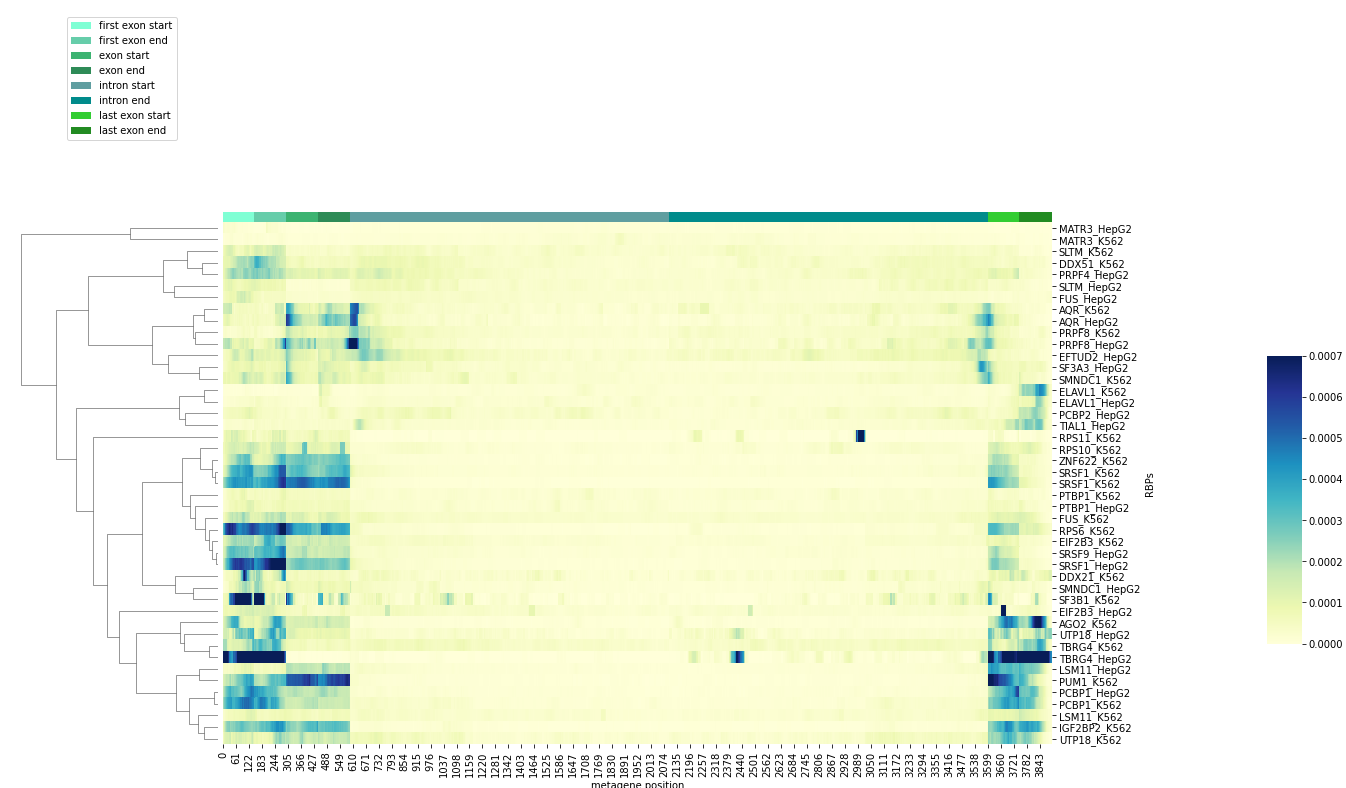

In [13]:
ylabelnames = with_data['RBP']+'_'+with_data['Cell line']
g = sns.clustermap(df, 
                   metric ="correlation", method = "complete",
                   row_cluster = True,
                   col_colors = rna_color, col_cluster = False,
                   yticklabels=ylabelnames,
                   figsize=(16, 10), cmap = 'YlGnBu', cbar_pos=(1.1, .2, .03, .4), colors_ratio = 0.015, vmax = 0.0007)
g.ax_heatmap.set_ylabel('RBPs')
g.ax_heatmap.set_xlabel('metagene position')

for label in names:
    g.ax_col_dendrogram.bar(0, 0, color=color_dict[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="best", bbox_to_anchor=(-0.05, 1.5), ncol=1)
g.savefig("cluster_rna.svg", dpi = 300, format = 'svg')

# let's do it for another feature

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/seaborn-0.11.0-py3.7.egg/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


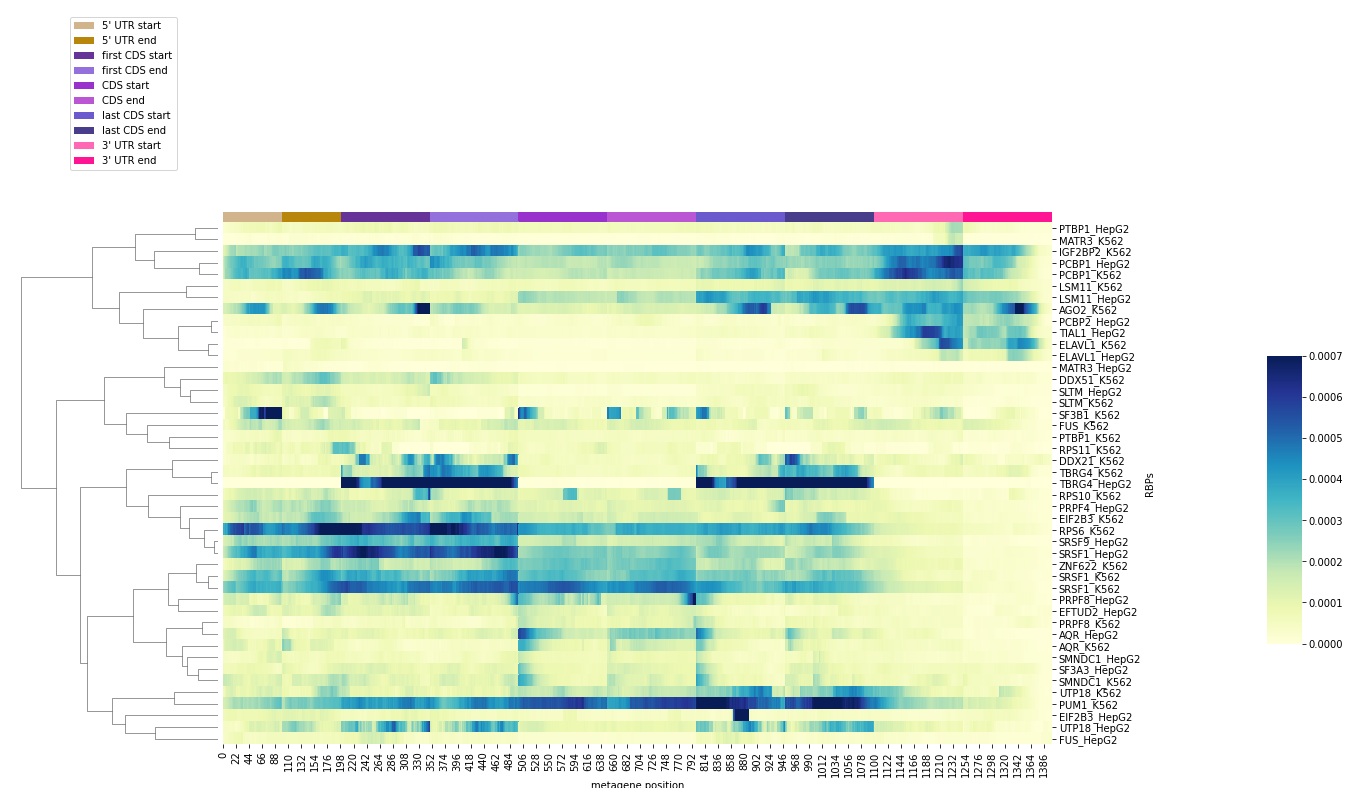

In [14]:
df, flen = into_one_df(with_data['uid'].tolist(), protein_coding)
cds_color, names = get_feat_color(protein_coding, flen)

ylabelnames = with_data['RBP']+'_'+with_data['Cell line']
g = sns.clustermap(df, 
                   metric ="correlation", method = "complete",
                   row_cluster = True,
                   col_colors = cds_color, col_cluster = False,
                   yticklabels=ylabelnames,
                   figsize=(16, 10), cmap = 'YlGnBu', cbar_pos=(1.1, .2, .03, .4), colors_ratio = 0.015, vmax = 0.0007)
g.ax_heatmap.set_ylabel('RBPs')
g.ax_heatmap.set_xlabel('metagene position')

for label in names:
    g.ax_col_dendrogram.bar(0, 0, color=color_dict[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="best", bbox_to_anchor=(-0.05, 1.5), ncol=1)
g.savefig("cluster_cds.svg", dpi = 300, format = 'svg')

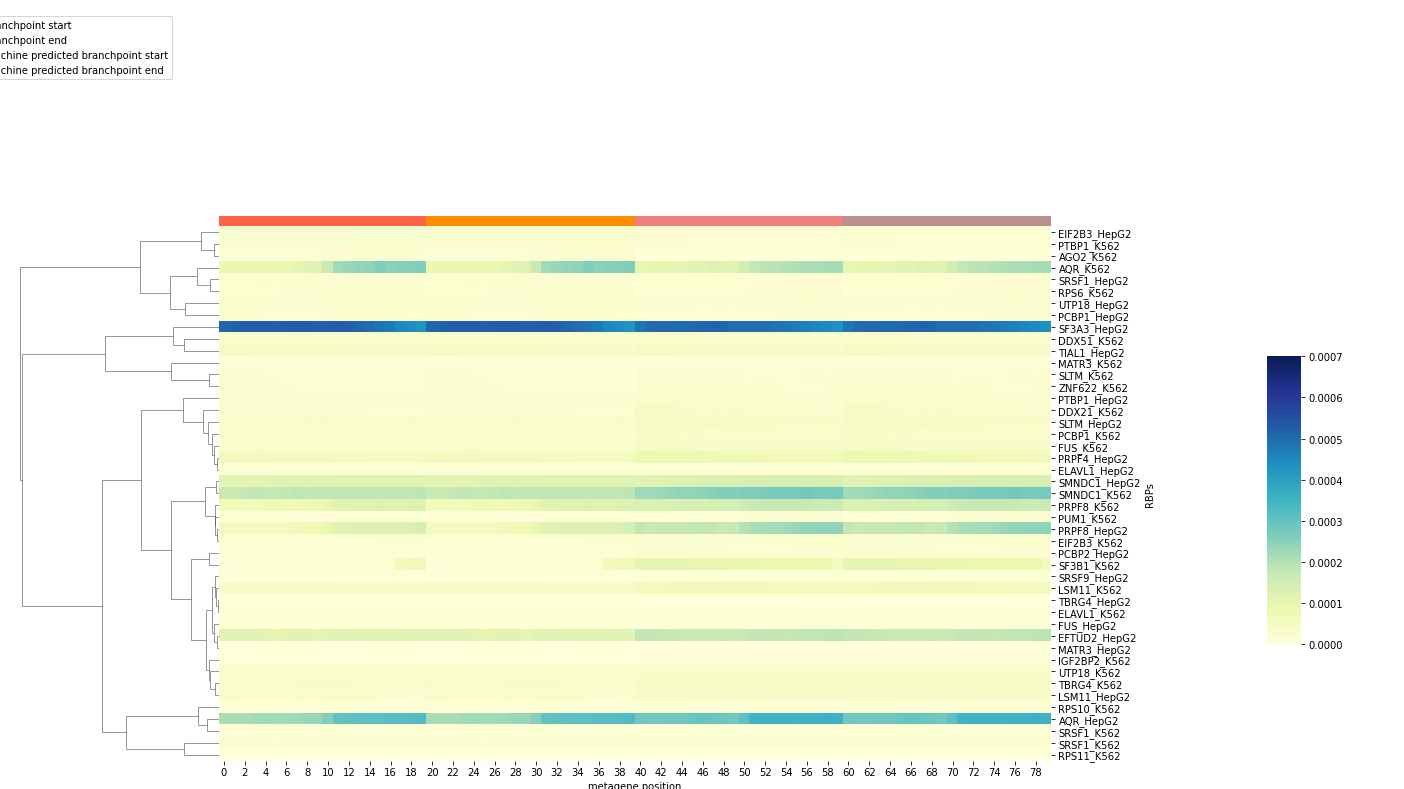

In [15]:
branchpoints = ['branchpoint', 'branchpoint_pred']
df, flen = into_one_df(with_data['uid'].tolist(), branchpoints)
br_color, names = get_feat_color(branchpoints, flen)

ylabelnames = with_data['RBP']+'_'+with_data['Cell line']
g = sns.clustermap(df, 
                   metric ="correlation", method = "complete",
                   row_cluster = True,
                   col_colors = br_color, col_cluster = False,
                   yticklabels=ylabelnames,
                   figsize=(16, 10), cmap = 'YlGnBu', cbar_pos=(1.1, .2, .03, .4), colors_ratio = 0.015, vmax = 0.0007)
g.ax_heatmap.set_ylabel('RBPs')
g.ax_heatmap.set_xlabel('metagene position')

for label in names:
    g.ax_col_dendrogram.bar(0, 0, color=color_dict[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="best", bbox_to_anchor=(-0.05, 1.5), ncol=1)
g.savefig("cluster_br.svg", dpi = 300, format = 'svg')